## Install Dependencies

In [1]:
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.7/212.7 kB 26.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tokenizers
Failed to build tokenizers
ERROR: Could not build wheels for tokenizers, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.5/507.5 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentencepiece: filename=sentencepiece-0.1.94-c

## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [ ]:
%reset -f

## Import Libraries

In [3]:
# General libraries
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [ ]:
torch.cuda.empty_cache()

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [ ]:
# !pip install git+https://github.com/csebuetnlp/normalizer

In [5]:
# import banglanltk as bn
# from normalizer import normalize

# from datasets import load_dataset
# import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [6]:
PATH_DATA = "/content/gdrive/MyDrive/Study/NLP/chatbot/data/poem.csv"
model = T5ForConditionalGeneration.from_pretrained("csebuetnlp/banglat5")
MODEL_NAME = "csebuetnlp/banglat5"

SEED = 1

# Specified in the number of tokens
INP_MAX_LEN = 128
OUT_MAX_LEN = 512

TRAIN_BATCH_SIZE = 4

N_EPOCHS = 10
LR = 1e-3

PREFIX = "কবিতা বানাও: " # The T5 prefix to append to the inputs
SENT_SEP = "|" # All newlines/multi-newlines are replaced by a single '|' as T5Tokenizer replaces "\n" by a space
TOPIC_SEP = ", " # Delimiter used for separating the topics in the input

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [26]:
# Set random seeds and make pytorch deterministic for reproducibility
# Reference: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md
def setSeed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
setSeed()

## Helper Functions

In [20]:
def countParameters(model):
    """ Counts the total number of trainable and frozen/non-trainable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Custom Dataset

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len # All input sequences would be padded to this length
        self.out_len = out_len # All output sequences would be padded to this length

        self.inp_txt = self.df.input
        self.out_txt = self.df.output


    def __len__(self):
        return len(self.out_txt)


    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len,
            padding = "max_length",
            truncation = True,
            return_tensors = "pt"
        )

        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len,
            padding = "max_length",
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source["input_ids"].squeeze() # squeeze() to remove the additional dimension
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        # Don't shift the inputs/outputs to GPU now, do it while loading the batches, and then shift the entire batch at once

        return {
            "source_ids"  : source_ids,
            "source_mask" : source_mask,
            "target_ids"  : target_ids,
            "target_mask" : target_mask
        }

## Data Handlers

In [ ]:
def replaceSep(text, sep = SENT_SEP):
    """ Replaces all signle/multi-linebreaks by a single 'sep' everywhere, as T5Tokenizer just replaces '\n' by a blank space """
    corrupted_sentences = text.split("\n")
    sentences = [s.strip() for s in corrupted_sentences if len(s.strip()) > 1] # Only keep sentences of length > 1
    text = sep.join(sentences)
    return text

In [ ]:
def loadDF(path, n_rows = None, prefix = PREFIX):
    """ Loads the CSV data, converts it to the specified format, and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")

    # Drop the NaN rows (if any)
    df.dropna(inplace = True)

    # Choose the approproate columns containing the text input and the text output
    df = df[["content", "name"]]

    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"content" : "output", "name" : "input"}, inplace=True)

    # Add a suitable prefix to the text input
    df["input"] = prefix + df["input"]

    # Truncate the dataset if specified
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Replace newlines in the poem
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)

    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [ ]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)

    # Create Dataloaders
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)

    return dl_train, dl_val

## Train and Validate Functions

In [ ]:
def train(tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE)
        source_mask = batch["source_mask"].to(DEVICE)
        target_mask = batch["target_mask"].to(DEVICE)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids,
            attention_mask = source_mask,
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss

        loss_batches.append(loss.item())

        # Compute gradients
        loss.backward()

        # Update parameters
        optimizer.step()

    # Average epoch loss:
    avg_epoch_loss = sum(loss_batches) / len(loss_batches)

    return avg_epoch_loss

## Generation

### Sampling

In [21]:
def genSample(topics, min_length, max_length, rep_penalty = 1, temp = 1, top_k = 50, top_p = 1.0, no_repeat_ngram_size = 3, num_return_sequences = 2, already_formatted = False):

    setSeed() # Required to ensure reproducibility

    if not already_formatted:
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model.generate(
            do_sample = True,
            input_ids = input_ids,
            min_length = min_length,
            max_length = max_length,
            top_p = top_p,
            top_k = top_k,
            temperature = temp,
            repetition_penalty = rep_penalty,
            no_repeat_ngram_size = no_repeat_ngram_size, # Don't repeat any n-grams of this size
            num_return_sequences = num_return_sequences
        )

    for i, generated_ids in enumerate(output):
        gen = tokenizer.decode(generated_ids, skip_special_tokens = True, clean_up_tokenization_spaces = True)
        sentences = gen.split(SENT_SEP)
        for s in sentences:
            print(s.strip())
        print("\n")

    return gen

### Beam Search

In [32]:
def genBeam(topics, min_length, max_length, rep_penalty = 1, n_beams = 2, no_repeat_ngram_size = 3, num_return_sequences = 2, already_formatted = False):

    setSeed() # Required to ensure reproducibility

    if not already_formatted:
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    model.eval()
    with torch.no_grad():
        output = model.generate(
            input_ids = input_ids,
            min_length = min_length,
            max_length = max_length,
            num_beams = n_beams,
            no_repeat_ngram_size = no_repeat_ngram_size, # Don't repeat any n-grams of this size
            repetition_penalty = rep_penalty,
            num_return_sequences = num_return_sequences
        )

    for generated_ids in output:
        gen = tokenizer.decode(generated_ids, skip_special_tokens = True, clean_up_tokenization_spaces = True)
        sentences = gen.split(SENT_SEP)
        for s in sentences:
            print(s.strip())
        print("\n")

    return gen

## Main

### Tokenizer

In [28]:
# T5's Tokenzier for encoding the text
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglat5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
example_text = "প্রশ্নটির উত্তর দাও:"
example_input_ids = tokenizer(
    example_text,
    return_tensors = "pt"
).input_ids[0]
print(len(example_input_ids))
example_decoded = [tokenizer.decode(i, skip_special_tokens = True, clean_up_tokenization_spaces = True) for i in example_input_ids]
print(example_decoded)

6
['প্রশ্ন', 'টির', 'উত্তর', 'দাও', ':', '']


### Loading the Data

In [ ]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = PREFIX)
print(len(df), len(df_train), len(df_val))

2234 2229 5


In [ ]:
display(df)

,output,input
0,"বজাও রে মোহন বাঁশি।|সারা দিবসক|বিরহদহনদুখ,|মরম...",কবিতা বানাও: ১০
1,"শুনহ শুনহ বালিকা,|রাখ কুসুমমালিকা,|কুঞ্জ কুঞ্জ...",কবিতা বানাও: ২
2,"হৃদয়ক সাধ মিশাওল হৃদয়ে,|কন্ঠে বিমলিন মালা।|বির...",কবিতা বানাও: ৩
3,"আজু সখি, মুহু মুহু|গাহে পিক কুহু কুহু,|কুঞ্জবন...",কবিতা বানাও: ১১
4,"সজনি সজনি রাধিকা লো|দেখ অবহু চাহিয়া,|মৃদুলগমন ...",কবিতা বানাও: ৫
...,...,...
2229,‘ হায় গগন নহিলে|তোমারে ধরিবে কে বা|ওগো তপন তোম...,কবিতা বানাও: ১২
2230,"বাহির হইতে দেখো না এমন করে,|আমায় দেখো না বাহির...",কবিতা বানাও: ২১
2231,"সব ঠাঁই মোর ঘর আছে, আমি|সেই ঘর মরি|খুঁজিয়া।|দে...",কবিতা বানাও: ১৪
2232,আকাশ - সিন্ধু - মাঝে এক ঠাঁই|কিসের বাতাস|লেগেছ...,কবিতা বানাও: ১৫


In [ ]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

558 2


In [ ]:
def countTokens(text):
    input_ids = tokenizer(
        text,
        return_tensors = "pt"
    ).input_ids[0]
    return len(input_ids)

In [ ]:
df["input_length"] = df["input"].apply(countTokens)
df["output_length"] = df["output"].apply(countTokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Use this to select INP_MAX_LEN and OUT_MAX_LEN
print("Input Length (in tokens) Statistics")
print(df["input_length"].describe())
print()
print("Output Length (in tokens) Statistics")
print(df["output_length"].describe())

Input Length (in tokens) Statistics
count    2234.000000
mean        7.529543
std         0.899458
min         7.000000
25%         7.000000
50%         7.000000
75%         8.000000
max        17.000000
Name: input_length, dtype: float64

Output Length (in tokens) Statistics
count    2234.000000
mean      348.988362
std       499.568419
min         2.000000
25%       129.000000
50%       214.500000
75%       401.500000
max      8981.000000
Name: output_length, dtype: float64


### Loading the Model

In [7]:
# model = T5ForConditionalGeneration.from_pretrained("csebuetnlp/banglat5")
model = torch.load('/content/gdrive/MyDrive/Study/NLP/chatbot/model_10epochs.h5')
model = model.to(DEVICE)

In [18]:
# Print the model architecture
# print(model)

print("Is the model on CUDA?", next(model.parameters()).is_cuda)

Is the model on CUDA? True


In [22]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 247,577,856 trainable and 0 frozen parameters


### Optimization

In [ ]:
optimizer = Adafactor(
    params = model.parameters(),
    lr = LR,
    scale_parameter = False,
    relative_step = False
)

In [ ]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}/{N_EPOCHS}")
    loss_epoch = train(tokenizer, model, dl_train, optimizer)
    losses.append(loss_epoch)

Epoch 1/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 2/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 3/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 4/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 5/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 6/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 7/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 8/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 9/10


  0%|          | 0/558 [00:00<?, ?it/s]

Epoch 10/10


  0%|          | 0/558 [00:00<?, ?it/s]

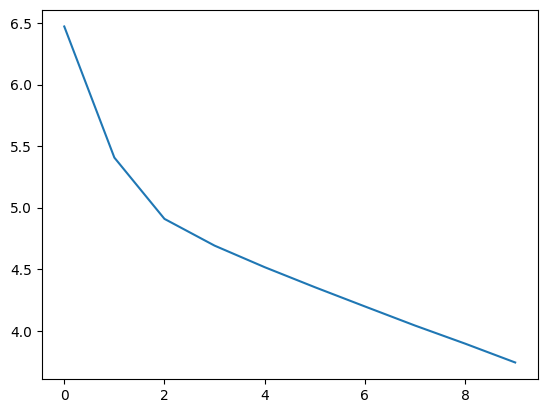

In [ ]:
plt.plot(range(len(losses)), losses)
plt.show()

### Generation

In [ ]:
val_list = df_val["input"].tolist()
for inp in val_list:
    print(f"Input: {inp}")
    genSample(
        topics = inp,
        min_length = 0,
        max_length = 500,
        rep_penalty = 1.3,
        temp = 0.9,
        top_k = 50,
        top_p = 0.95,
        no_repeat_ngram_size = 3,
        num_return_sequences = 1,
        already_formatted = True
    )
    print("\n\n")

In [ ]:
# Generate using Beam Search (usually very repetetive)
for inp in val_list:
    print(f"Input: {inp}")
    genBeam(
        topics = inp,
        min_length = 0,
        max_length = 500,
        rep_penalty = 1.5,
        n_beams = 2,
        no_repeat_ngram_size = 3,
        num_return_sequences = 1,
        already_formatted = True
    )
    print("\n\n")

Input: কবিতা বানাও: প্রণতি
আমারে তুমি করেছ সৃষ্টি,
তুমি মোরে করেছ সৃষ্টি।
আমি তোমারে করেছি সৃষ্টি, তাই
তোমারে করেছি সৃজন।
আমারে তুমি কর নি সৃজন,
আমি করি নি সৃজন।





Input: কবিতা বানাও: শুকতারা
তোমার
আঁখির পানে চেয়ে থাকি,
তোমার
নয়নের পানে
চেয়ে থাকি।
তুমি
আমায়
দেখছ চেয়ে,
আমার
নয়নে
আঁধার লেগে আছে।
আমি
তোমায়
দেখি না যে,
ওই - যে ওই - যে
ছায়াখানি
পড়ে আছে
তোমার মুখের 'পরে।
তোমার ছায়াখানি
আঁচল দিয়ে ঢাকে,
আঁধারেতে ঢাকে।
অরুণ-আলোর
ছায়াটি
পড়ে আমার
চোখে।
এ - যে আলোটি
পড়ছে এসে
তোমার মুখে।





Input: কবিতা বানাও: নবীন অতিথি
আমার অতিথি,
তোমার অতিথি।
আমার অতিথি, তোমার অতিথি।
তোমার অতিথির বেশে আসি,
দুয়ারে দাঁড়িয়ে থাকি।
তোমার ভৃত্য, তোমার ভৃত্য,
তুমি যে অতিথি, তুমি যে অতিথি!
তোমারি অতিথি, হে অতিথি, ওগো অতিথি, তব
অতিথি।
ওগো অতিথি, তোমাদের অতিথি, এ কি তোমার কাজ?
এ কি তোমার কাজের তরে?
তোমারই অতিথি তুমি, হে বিদেশী,
এ কী তোমার কাজ!
এ তো তোমার কাজ
এ যে তোমার খেলা, এ তো তোমার খেলা।
একি তোমার অতিথি?
আমি অতিথি, আমি অতিথি।





Input: কবিতা বানাও: স্পর্ধা
তোমার কাছে আমি হার মেনেছি,
তোমার কাছে 

In [34]:
sample_topics = ["শহরের ভালোবাসা ", "শহরের", "ভালোবাসা"]

In [35]:
gen = genSample(
    topics = sample_topics,
    min_length = 0,
    max_length = 500,
    rep_penalty = 1.3,
    temp = 0.9,
    top_k = 50,
    top_p = 0.9,
    no_repeat_ngram_size = 3,
    num_return_sequences = 3,
    already_formatted = False
)

মনে হয় যেন সেই চির - জীবন ছিল আমারি,
প্রতিদিবসের নিত্য ভালোবাসা।
চিরদিনকারে আমি করেছি অনুভব
এ প্রাণ মোর আজন্মকাল
অতীত কালের বিস্মৃত ইতিহাস?
আজিকার এই চিরপ্রত্যাশিত কাহিনী।
মোর জন্মপূর্ব হতে এ প্রেমের ধারা
কেটেছে লেখা, পেয়েছি তাহা খুঁজে খুঁজি,
কত যুগ ধরি কত কাল ধরে আছিল মনে।
সেদিন প্রথম দেখা হয়েছিল যে-ফুলে
প্রভাতকালে কী প্রত্যাশা করেছিল বহন ;
সে - বাণী যেন আজ তারি হয়ে গেল গত।
হয়তো সেদিন মনে আছে তাহার চেয়ে এক কোণে!


এ কী, একি রে ভালোবাসা? '
সে কি, বন্ধু মোর! তারে বাসি ভালো।
তবু কি হৃদয়ের কোণের কাছে
এ বিরহ-স্বপনে ফিরিবার আছে কি!
তাহে হৃদয়ের ব্যথা
নিখিলের প্রেমে কি রয়েছে লিখা?
যে সুধার গভীরে উৎসারিয়া উঠে নি ফুটে ;
তাহারে তাই করিয়াছি অনুভব,
যাহা সত্য তাই আপনার মধ্যে আনিছে টানি।
তাই আজি সেথা আসে না কথা, যায় নাই বাণী।
চিরদিন এই সুখদুঃখ যত
প্রতি ক্ষণে আমার হৃদয়-অশ্রুজলে, ভাসে অশ্রুজলে।


যে-হেনকালে প্রাতে
তোমারে চিনি যবে নববসন্তে
যেদিন তুমি এসেছিলে অনাহূত অতিথি,
সেইক্ষণে তোমারি অভিসারে
সে-পথ হতে আমি তোমারে আহ্বান করেছি,
তখন তোমারি কণ্ঠস্বর বাজে।
তব বাণীর ছন্দে তোমারে করিনু সন্ধান

In [33]:
gen = genBeam(
    topics = sample_topics,
    min_length = 0,
    max_length = 500,
    rep_penalty = 1.5,
    n_beams = 2,
    no_repeat_ngram_size = 3,
    num_return_sequences = 2,
    already_formatted = False
)

তোমার কাছে আমি যাই নি তো আর,
তোমার কাছে যাই নি যে আর।
আমি শুধু যাই নাই যে আর ফিরে।
তুমি যাও নি যে চলে,
সেথায় তুমি যাও নি কি আর ফিরে?
ওগো, সন্ধ্যা হয়ে আসে,
আঁধার হয়ে আসে রাতি,
আমারে শুধু ডেকে লও গো ডাকি,
আমায় শুধু ডাকে,
আমায় শুধু বলে, আমায় কেবল ডাকে
আমি চলি নি যে যেতে যেতে
তোমায় শুধু ডেকেছি যে,
তাই তো আমি যাই না যে আর ঘরে।


তোমার কাছে আমি যাই নি তো আর,
তোমার কাছে যাই নি যে আর।
আমি শুধু যাই নাই যে আর ফিরে।
তুমি যাও নি যে চলে,
সেথায় তুমি যাও নি কি আর ফিরে?
ওগো, সন্ধ্যা হয়ে আসে,
আঁধার হয়ে আসে রাতি,
আমারে শুধু ডেকে লও গো ডাকি,
আমায় শুধু ডাকে,
আমায় শুধু বলে, আমায় কেবল ডাকে
আমি চলি নি যে যেতে যেতে
তোমায় শুধু ডেকেছি যে,
তাই তো আমি যাই না যে আর ঘরে।
একেলা বসে থাকি,
একি এ মোর আশা।
এ কি এ মোর চাওয়া,
আমি যাই নি সে আর ফিরে!




### Save the finetuned model

In [ ]:
torch.save(model, f"/content/gdrive/MyDrive/Study/NLP/chatbot/poetry_t5Bangla")

In [ ]:
torch.save(model, f"/content/gdrive/MyDrive/Study/NLP/chatbot/model_{N_EPOCHS}epochs.h5")